In [22]:
import numpy as np 
from scipy.interpolate import interp1d
# -- astropy -- 
import astropy.time
import astropy.coordinates
import astropy.units as u 
from astropy.io import fits
# -- feasibgs --
from feasibgs import util as UT
from feasibgs import skymodel as Sky
# -- others -- 
import speclite
import specsim.simulator

In [8]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
fdecam = fits.open(''.join([UT.dat_dir(), 'decalsobs-zpt-dr3-allv2.fits']))
decam = fdecam[1].data

In [4]:
keep = (decam['AIRMASS'] != 0.0)
print("%i of %i have airmass != 0." % (np.sum(keep), decam['AIRMASS'].shape[1]))

26561 of 27491 have airmass != 0.


In [6]:
time = astropy.time.Time(decam['DATE'], format='jd')
location = astropy.coordinates.EarthLocation.from_geodetic(
    lat='-30d10m10.78s', lon='-70d48m23.49s', height=2241.4*u.m)

moon_position = astropy.coordinates.get_moon(time, location)
moon_ra = moon_position.ra.value
moon_dec = moon_position.dec.value
moon_position_altaz = moon_position.transform_to(astropy.coordinates.AltAz(obstime=time, location=location))
moon_alt = moon_position_altaz.alt.value
moon_az = moon_position_altaz.az.value

def separation(ra1, dec1, ra2, dec2):
    pi2 = np.radians(90)
    alpha = np.cos(np.radians(ra1)-np.radians(ra2))
    first = np.cos(pi2-np.radians(dec1))*np.cos(pi2-np.radians(dec2))
    second = np.sin(pi2-np.radians(dec1))*np.sin(pi2-np.radians(dec2))*alpha
    return np.arccos(first+second)*180/np.pi

separation_angle = separation(decam['RA'], decam['DEC'], ra2=moon_ra, dec2=moon_dec)

(0.0, 1.0)

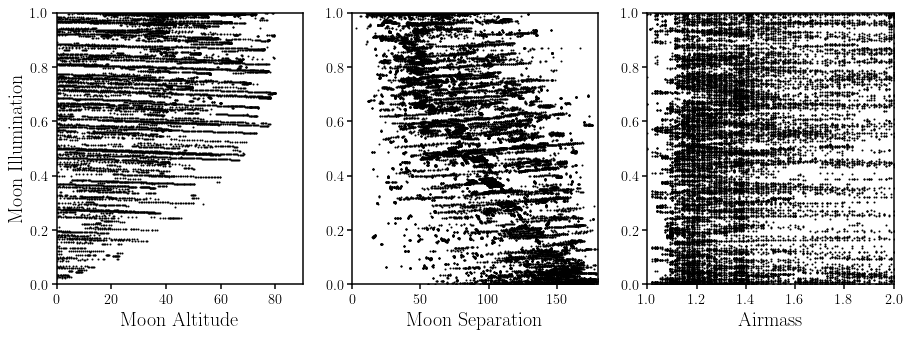

In [9]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(moon_alt, decam['MOONPHASE'], c='k', s=1)
#sub.scatter(boss_blue['MOON_ALT'], boss_blue['MOON_ILL'], c='k', s=1)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([0., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0., 1.])
sub = fig.add_subplot(132)
sub.scatter(decam['MOONSEP'], decam['MOONPHASE'], c='k', s=1)
#sub.scatter(boss_blue['MOON_SEP'], boss_blue['MOON_ILL'], c='k', s=1)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([0., 180.])
sub.set_ylim([0., 1.])
sub = fig.add_subplot(133)
sub.scatter(decam['AIRMASS'], decam['MOONPHASE'], c='k', s=1)
#sub.scatter(boss_blue['AIRMASS'], boss_blue['MOON_ILL'], c='k', s=1)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylim([0., 1.])

In [46]:
import pandas as pd
f = ''.join([UT.code_dir(), 'dat/sky/MoonResults.csv'])

coeffs = pd.DataFrame.from_csv(f)
coeffs.columns = [
    'wl', 'model', 'data_var', 'unexplained_var',' X2', 'rX2',
    'c0', 'c_am', 'tau', 'tau2', 'c_zodi', 'c_isl', 'sol', 'I',
    't0', 't1', 't2', 't3', 't4', 'm0', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6',
    'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec',
    'c2', 'c3', 'c4', 'c5', 'c6']
# keep moon models
twi_coeffs = coeffs[coeffs['model'] == 'twilight']
coeffs = coeffs[coeffs['model'] == 'moon']
# order based on wavelengths for convenience
wave_sort = np.argsort(np.array(coeffs['wl']))

for k in coeffs.keys():
    coeffs[k] = np.array(coeffs[k])[wave_sort]

for k in twi_coeffs.keys():
    twi_coeffs[k] = np.array(twi_coeffs[k])[wave_sort]

def cI_twi(alpha, delta, airmass): 
    twi = (
        twi_coeffs['t0'] * np.abs(alpha) + # CT2
        twi_coeffs['t1'] * np.abs(alpha)**2 +      # CT1
        twi_coeffs['t2'] * np.abs(delta)**2 +      # CT3
        twi_coeffs['t3'] * np.abs(delta)           # CT4
    ) * np.exp(-twi_coeffs['t4'] * airmass) + twi_coeffs['c0']
    return np.array(twi)

specsim_sky = Sky.specsim_initialize('desi')
specsim_wave = specsim_sky._wavelength # Ang

cr_def = specsim_sky.moon.KS_CR
cm0_def = specsim_sky.moon.KS_CM0
cm1_def = specsim_sky.moon.KS_CM1

def KSsky(airmass, moonill, moonalt, moonsep): 
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg
    specsim_sky.moon.KS_CR = cr_def
    specsim_sky.moon.KS_CM0 = cm0_def
    specsim_sky.moon.KS_CM1 = cm1_def
    return specsim_sky.surface_brightness.value


def KSrescaled_twi_sky(airmass, moonill, moonalt, moonsep, sun_alt, sun_sep): 
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg
    specsim_sky.moon.KS_CR = 458173.535128
    specsim_sky.moon.KS_CM0 = 5.540103
    specsim_sky.moon.KS_CM1 = 178.141045
    I_ks_rescale = specsim_sky.surface_brightness
    if sun_alt > -20.: 
        I_twi = cI_twi(sun_alt, sun_sep, airmass)/np.pi
        I_twi_interp = interp1d(10.*np.array(coeffs['wl']), I_twi, fill_value='extrapolate')
        return I_ks_rescale.value + I_twi_interp(specsim_wave.value)
    else: 
        return I_ks_rescale.value

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.


In [17]:
cut_g = (decam['FILTER'] == 'g') & (moon_alt > 10.) & (decam['TRANSP'] > .75) & (decam['TRANSP'] < 1.3) & keep
cut_r = (decam['FILTER'] == 'r') & (moon_alt > 10.) & (decam['TRANSP'] > .75) & (decam['TRANSP'] < 1.3) & keep
cut_z = (decam['FILTER'] == 'z') & (moon_alt > 10.) & (decam['TRANSP'] > .75) & (decam['TRANSP'] < 1.3) & keep

In [52]:
def get_KSsky_mag(band):  
    filter_response = speclite.filters.load_filter('decam2014-{}'.format(band))
    
    if band == 'g': cut = cut_g 
    elif band == 'r': cut = cut_r
    elif band == 'z': cut = cut_z
    nrows = np.sum(cut)
    sky_brightness = np.empty(nrows, dtype=float)

    for i in range(nrows):
        scattered_moon = KSsky(
            decam['AIRMASS'][cut][i], 
            decam['MOONPHASE'][cut][i], 
            moon_alt[cut][i], 
            separation_angle[cut][i])
        scattered_moon = scattered_moon * 1e-17 * u.erg / (u.Angstrom * u.cm ** 2 * u.s)
        moon_flux, sky_wlen = filter_response.pad_spectrum(scattered_moon, specsim_wave)
        sky_brightness[i] = filter_response.get_ab_maggies(moon_flux, sky_wlen)
    return flux_to_mag(sky_brightness)


def get_newSky_band(band):  
    filter_response = speclite.filters.load_filter('decam2014-{}'.format(band))
    
    if band == 'g': cut = cut_g 
    elif band == 'r': cut = cut_r
    elif band == 'z': cut = cut_z
    nrows = np.sum(cut)
    sky_brightness = np.empty(nrows, dtype=float)

    for i in range(nrows):
        scattered_moon = KSrescaled_twi_sky(
            decam['AIRMASS'][cut][i], 
            decam['MOONPHASE'][cut][i], 
            moon_alt[cut][i], 
            separation_angle[cut][i], 
            decam['SUNALT'][cut][i], 
            decam['SUNSEP'][cut][i])
        scattered_moon = scattered_moon * 1e-17 * u.erg / (u.Angstrom * u.cm ** 2 * u.s)
        moon_flux, sky_wlen = filter_response.pad_spectrum(scattered_moon, specsim_wave)
        sky_brightness[i] = filter_response.get_ab_maggies(moon_flux, sky_wlen)
    return flux_to_mag(sky_brightness)


def flux_to_mag(flux):
    return 22.5 - 2.5*np.log10(flux*10**9)

In [37]:
newsky_g = get_newSky_band('g')

In [39]:
newsky_r = get_newSky_band('r')

In [40]:
newsky_z = get_newSky_band('z')

In [53]:
ks_g = get_KSsky_mag('g')
ks_r = get_KSsky_mag('r') 
ks_z = get_KSsky_mag('z') 

(16, 22)

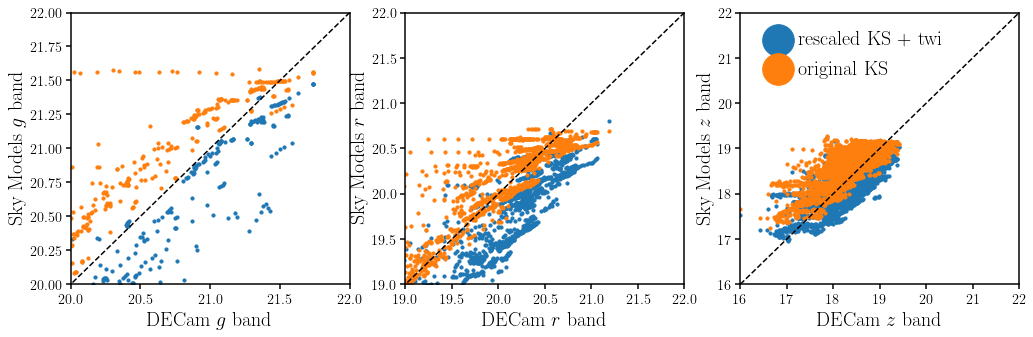

In [57]:
fig = plt.figure(figsize=(17,5))
sub = fig.add_subplot(131)
sub.scatter(decam['SKYBR'][cut_g], newsky_g, s=10, lw=1)
sub.scatter(decam['SKYBR'][cut_g], ks_g, s=10, lw=1)
sub.plot([16, 22], [16, 22], c='k', ls='--')
sub.set_xlabel('DECam $g$ band', fontsize=20)
sub.set_xlim([20., 22])
sub.set_ylabel('Sky Models $g$ band', fontsize=20)
sub.set_ylim([20., 22])

sub = fig.add_subplot(132)
sub.scatter(decam['SKYBR'][cut_r], newsky_r, s=10, lw=1)
sub.scatter(decam['SKYBR'][cut_r], ks_r, s=10, lw=1)
sub.plot([16, 22], [16, 22], c='k', ls='--')
sub.set_xlabel('DECam $r$ band', fontsize=20)
sub.set_xlim([19, 22])
sub.set_ylabel('Sky Models $r$ band', fontsize=20)
sub.set_ylim([19, 22])

sub = fig.add_subplot(133)
sub.scatter(decam['SKYBR'][cut_z], newsky_z, s=10, lw=1, label='rescaled KS + twi')
sub.scatter(decam['SKYBR'][cut_z], ks_z, s=10, lw=1, label='original KS')
sub.plot([16, 22], [16, 22], c='k', ls='--')
sub.legend(loc='upper left', markerscale=10, handletextpad=0, fontsize=20)
sub.set_xlabel('DECam $z$ band', fontsize=20)
sub.set_xlim([16, 22])
sub.set_ylabel('Sky Models $z$ band', fontsize=20)
sub.set_ylim([16, 22])